In [233]:
from PIL import Image
import numpy as np
import pandas as pd
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import keras
import os
from keras import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from io import BytesIO
%matplotlib inline

In [235]:
folder_names = ["burger", "cheesecake", "frenchfries", "pizza"]
folder_array = [np.array([0,0,0,0,1]),np.array([0,0,0,1,0]),np.array([0,0,1,0,0]),np.array([0,1,0,0,0])]
num_classes = len(folder_names) + 1

Checks if all the folders are present in the working directory.

In [234]:
for dir_name in folder_names:
    dir_exists = os.path.isdir(dir_name)
    if not dir_exists:
        print("{} not found, exiting application".format(dir_name))
        exit(1)

Function to scale down all the images to a 200 x 200 image. The scaled images are then stored in a new folder to be used to train the convolutional neural network. 

In [59]:
def resizeImages(dir_name):
    dirs = os.listdir(dir_name)
    os.mkdir(dir_name+"_resized")
    for item in dirs:
        if (item == ".DS_Store"): continue
        if os.path.isfile(dir_name+'/'+item):
                im = Image.open(dir_name+'/'+item)
                f, e = os.path.splitext(dir_name+"_resized/"+item)
                imResize = im.resize((200,200), Image.ANTIALIAS)
                imResize.save(f + ' resized.jpg', 'PNG', quality=90)
        else:
            print("UH OH")


Resizing all the images in the training dataset to be of the same size. 

In [ ]:
for folder in folder_names:
    resizeImages(folder)

Converts all the images in the directory to a numpy array and then returns a list containing numpy arrays for images corresponding to a certain category of food. 

In [62]:
def convertImageToNumpyArray(dir_name):
    image_arr = []
    dirs = os.listdir(dir_name+"_resized")
    for item in dirs: 
        if (item == ".DS_Store"): continue
        im = Image.open(dir_name+"_resized/"+item)
        im.load()
        image_arr.append(np.asarray(im, dtype="int32"))
    return image_arr

In [254]:
training_images = []
for folder in folder_names:
    training_images.append(convertImageToNumpyArray(folder))

print(len(training_images))

4


In [255]:
num_examples = 0
for training_image in training_images:
    num_examples += len(training_image)

print(num_examples)

2904


In [256]:
X = np.zeros((num_examples, 200, 200, 3))
Y = np.zeros((num_examples, num_classes))

In [257]:
index = 0
for folder in range(len(folder_names)):
    for image in range(len(training_images[folder])):
        X[index, :, :, :] = training_images[folder][image]
        Y[index, :] = folder_array[folder]
        index += 1

In [ ]:
from sklearn.model_selection import train_test_split

X_tr, X_ts, Y_tr, Y_ts = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True)

print(X_tr[0].shape)

In [322]:
keras.backend.clear_session()

In [298]:
# try Tanh activation

In [299]:
input_shape = X_tr[0].shape

# Modify model layers to increase accuracy
# ------------------------------------------------
# Model 1
# ------------------------------------------------

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(2000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [323]:
input_shape = X_tr[0].shape

# Modify model layers to increase accuracy
# ------------------------------------------------
# Model 2
# ------------------------------------------------

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(2000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(500, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [324]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 198, 198, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 97, 97, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 64)        36928     
__________

In [325]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc = []
        self.acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))

history_cb = LossHistory()

In [326]:
from keras import optimizers

opt = optimizers.Adam(lr=0.01)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_tr, Y_tr, epochs=20, batch_size=42, validation_data=(X_ts, Y_ts), callbacks=[history_cb])

Train on 2323 samples, validate on 581 samples
Epoch 1/20
2323/2323 [==============================] - 358s 154ms/step - loss: 4.0440 - acc: 0.3706 - val_loss: 11.1896 - val_acc: 0.2806
Epoch 2/20
2323/2323 [==============================] - 353s 152ms/step - loss: 2.2353 - acc: 0.4016 - val_loss: 11.6626 - val_acc: 0.2668
Epoch 3/20
2323/2323 [==============================] - 3156s 1s/step - loss: 1.6815 - acc: 0.4085 - val_loss: 1.9925 - val_acc: 0.3580
Epoch 4/20
2323/2323 [==============================] - 363s 156ms/step - loss: 1.5012 - acc: 0.4546 - val_loss: 1.2029 - val_acc: 0.4871
Epoch 5/20
2323/2323 [==============================] - 362s 156ms/step - loss: 1.4030 - acc: 0.4787 - val_loss: 1.4838 - val_acc: 0.3632
Epoch 6/20
2323/2323 [==============================] - 367s 158ms/step - loss: 1.1453 - acc: 0.5213 - val_loss: 1.5748 - val_acc: 0.3718
Epoch 7/20
2323/2323 [==============================] - 357s 154ms/step - loss: 1.0899 - acc: 0.5019 - val_loss: 1.3085 - val

In [ ]:
model.save('reLu_59,080,821_9897_8072')

In [166]:
model = keras.models.load_model('')

In [328]:
mode21Hist = history_cb

Text(0,0.5,'Accuracy')

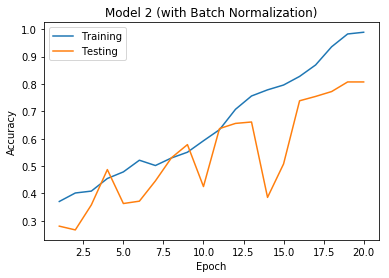

In [332]:
mode21Hist.acc.append(0.9887)
mode21Hist.val_acc.append(0.8072)
xVal = np.arange(1, 21, 1)
plt.plot(xVal, mode21Hist.acc)
plt.plot(xVal, mode21Hist.val_acc)
plt.title('Model 2 (with Batch Normalization)')
plt.legend(("Training", "Testing"), loc="best")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [303]:
model1Hist = history_cb

Text(0,0.5,'Accuracy')

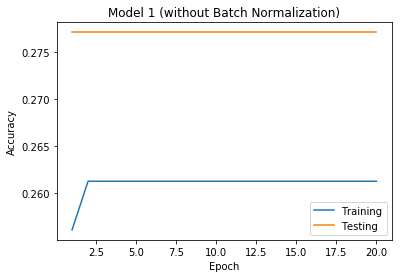

In [320]:
xVal = np.arange(1, 21, 1)
xValLoss = np.arange(1, 187, 1)
plt.plot(xVal, model1Hist.acc)
plt.plot(xVal, model1Hist.val_acc)
plt.title('Model 1 (without Batch Normalization)')
plt.legend(("Training", "Testing"), loc="best")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(xValLoss, model1Hist.loss)
plt.title('Model 1 (without Batch Normalization)')
plt.legend(("Loss"), loc="best")
plt.xlabel('Batch')
plt.ylabel('Loss')